# 

# Stock Price Prediction with Pandas and Scikit-Learn

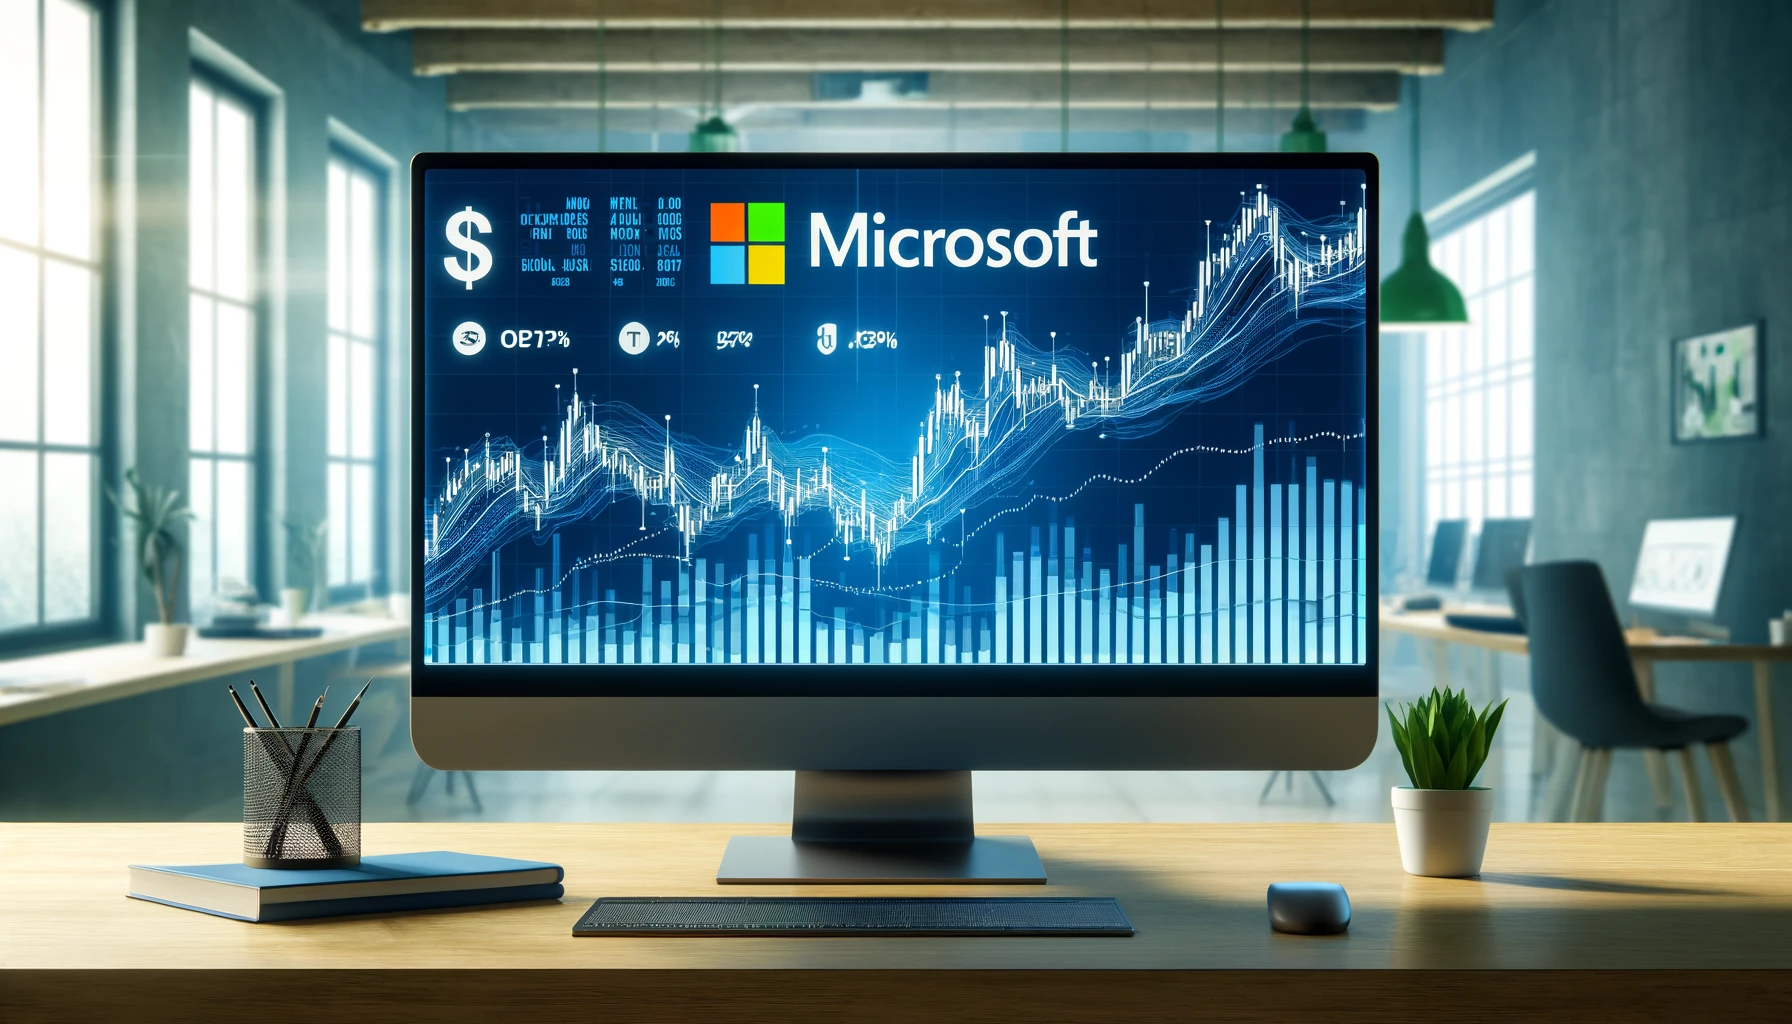

##### **Masoud Fattahi Bandpey , May 2024**


In this project, we will delve into predicting stock prices using pandas and scikit-learn. We will download stock prices, build a machine learning model, and create a backtesting engine. Additionally, we will cover key aspects of making this project an impressive addition to your data science portfoli).

First, let's connect the project to real-world applications. When developing a portfolio project, it's essential to consider its practical usage. Hiring managers prefer projects that closely resemble real-world data science tasks. Therefore, take time to determine the appropriate error metric and how your algorithm will be utilized.

For this project, let's assume we are trading stocks. Our objective is to make profitable trades while minimizing risk. To do this, we aim to buy stocks that are likely to increase in price. We'll buy stocks at market open and sell them at market close.

### Machine Learning Setup

To guide our trading decisions, we will train a machine learning model. This model will predict tomorrow's closing price based on today's data. If the model forecasts a price increase, we'll buy stock. If it predicts a decrease, we won't make a purchase.

Our goal is to maximize `true positives` - days when the model correctly predicts a price increase. Hence, we will use precision as our error metric, defined as `true positives / (false positives + true positives)`. This approach minimizes losses from `false positives` (days we buy stock, but the price decreases).

Consequently, we will tolerate more `false negatives` - days when we predict a price decrease, but it actually increases. This trade-off is acceptable as our priority is to minimize potential losses rather than maximize gains.

Thus, our model will have low `recall` but high `precision`. For more details on precision and recall, refer to [this resource](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics).

### Methodology

We will focus on Microsoft stock, identified by the ticker symbol `MSFT`. The steps to predict `MSFT` stock prices are as follows:

- Download MSFT stock prices from Yahoo Finance
- Explore the data
- Prepare the dataset to forecast future prices using historical data
- Test a machine learning model
- Implement a backtesting engine
- Enhance the model's accuracy

Finally, we will outline potential future improvements to refine our technique.

## Downloading the Data

To begin, we'll download stock data from Yahoo Finance using the `yfinance` Python package. You can install this package by running `pip install yfinance` in your command line or `!pip install yfinance` in a Jupyter notebook.

We'll retrieve data for Microsoft (MSFT) from its initial trading date to the present.


In [7]:
# !pip install yfinance

In [8]:

import yfinance as yf  # Import the yfinance package

# Create a Ticker object for Microsoft (MSFT)
msft = yf.Ticker("MSFT")

# Download the historical stock data for Microsoft from its first trading day to the present
msft_hist = msft.history(period="max")


We've now downloaded the data! In practice, it's beneficial to save this data to disk to avoid repeatedly calling the API. We can achieve this by checking if the data has already been saved. If it has, we load the data from disk; otherwise, we download it.

We'll need the `pandas` library for this task.


In [10]:
import os
import pandas as pd  # Import the pandas package

DATA_PATH = "msft_data.json"  # Define the path for the data file

if os.path.exists(DATA_PATH):
    # If the data file exists, load the data from the file
    msft_hist = pd.read_json(DATA_PATH)
else:
    # If the data file does not exist, download the data
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")
    # Save the downloaded data to a JSON file for future use
    msft_hist.to_json(DATA_PATH)


### Exploring the Data

Next, we'll examine the structure of the `msft_hist` DataFrame. We'll use the `.head` method on the [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to view the first 5 rows of data.

As shown below, each row represents a trading day for Microsoft stock. The columns include:

- **Open**: The price at which the stock opened.
- **High**: The highest price during the day.
- **Low**: The lowest price during the day.
- **Close**: The closing price at the end of the trading day.
- **Volume**: The number of shares traded.

The row index is the date of the trade. Note that stocks are not traded every day (e.g., weekends and holidays), so some dates will be missing.


In [12]:
# Display the first 5 rows of the DataFrame to understand its structure
msft_hist.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054693,0.062736,0.054693,0.060055,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060055,0.063272,0.060055,0.062199,308160000,0.0,0.0
1986-03-17 05:00:00,0.062199,0.063808,0.062199,0.063272,133171200,0.0,0.0
1986-03-18 05:00:00,0.063272,0.063808,0.061127,0.061663,67766400,0.0,0.0
1986-03-19 05:00:00,0.061663,0.062199,0.060055,0.060591,47894400,0.0,0.0


Next, let's visualize the data to observe how the stock price has changed over time. This will provide us with another perspective on the data structure. We can use the built-in [plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html?highlight=plot#pandas.DataFrame.plot) method on DataFrames for this purpose, utilizing the `use_index` parameter to use the index as the x-axis values.

Before plotting, ensure that `matplotlib` is installed.


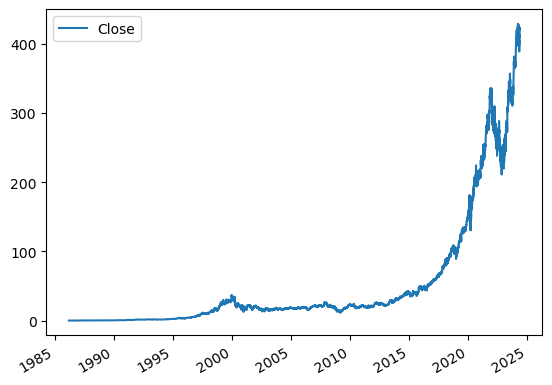

In [14]:
# Install matplotlib if you haven't already
# !pip install matplotlib

# Import the necessary plotting library
import matplotlib.pyplot as plt

# Plot the closing price of Microsoft stock over time
msft_hist.plot.line(y="Close", use_index=True)

# Display the plot
plt.show()


## Preparing the Data

Hopefully, you've stopped regretting not buying Microsoft stock in the past 30 years by now.

Let's prepare the data for making predictions. As discussed earlier, we'll predict whether the stock price will go up or down the next day based on today's data.

First, we'll create a target variable indicating whether the price will increase or decrease the next day. If the price goes up, the target will be `1`; if it goes down, the target will be `0`.

Next, we'll shift the data from previous days forward by one day to use it for predicting the target price. This step ensures we do not mistakenly use data from the same day to make predictions, a common error.

Finally, we'll combine the shifted data with the target variable to create our training dataset.

### Setting Up the Target

We'll start by setting up the target variable.

1. Copy the `Close` column to a new DataFrame called `data` and rename it to `actual_close`. This step ensures we retain the actual closing prices for each day, which is important as we'll be shifting data around.

2. Set up the target variable:
    * Use the pandas [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html?highlight=rolling#pandas.DataFrame.rolling) method across every 2 rows of the DataFrame. This method will compare each pair of consecutive rows.
    * Compare the second row's closing price to the first row's. If the second row's price is higher, return `1`; otherwise, return `0`.
    * Apply this comparison to the `Close` column.

The `Target` column now indicates if the price went up or down on a given day. If `Target` is `1`, the price went up; if `Target` is `0`, the price went down.

This target is what our machine learning model will predict!


In [16]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]].copy()
data = data.rename(columns={'Close': 'Actual_Close'})

# Set up our target variable to indicate if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Display the first few rows to verify the target setup
data.head()


,Actual_Close,Target
1986-03-13 05:00:00,0.060055,NaN
1986-03-14 05:00:00,0.062199,1.0
1986-03-17 05:00:00,0.063272,1.0
1986-03-18 05:00:00,0.061663,0.0
1986-03-19 05:00:00,0.060591,0.0


### Shifting Data "Forward"

Next, we'll use the DataFrame [shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html?highlight=shift#pandas.DataFrame.shift) method to move all rows "forward" by one trading day.

This process ensures that the prices for `1986-03-13` are now associated with `1986-03-14`, and every other price is similarly shifted up by one row. This ensures that we use past data to predict future prices.

Without this step, we would be using data from `03-14` to predict prices on `03-14`, which would make our model perform unrealistically well in tests but fail in real-world scenarios where future data isn't available.


In [18]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices using today's prices
msft_prev = msft_hist.shift(1)

# Display the first few rows to verify the shift
msft_prev.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.054693,0.062736,0.054693,0.060055,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060055,0.063272,0.060055,0.062199,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062199,0.063808,0.062199,0.063272,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063272,0.063808,0.061127,0.061663,6.776640e+07,0.0,0.0


### Combining Our Data

Next, we need to combine our `Target` variable with the columns we will use to predict this target. We'll use the [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join) method on DataFrames to achieve this.

After joining our data, we'll be predicting the target using data from the previous day. The columns we'll use to make these predictions are `["Close", "Volume", "Open", "High", "Low"]`.

Being explicit about the `predictors` helps ensure we don't inadvertently use the target variable to predict itself, which would make the model perform unrealistically well in training but fail in real-world applications.


In [20]:
# Specify the predictors
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Combine our target variable with the predictors from the previous day
data = data.join(msft_prev[predictors]).iloc[1:]

# Display the first few rows to verify the combination
data.head()


,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062199,1.0,0.060055,1.031789e+09,0.054693,0.062736,0.054693
1986-03-17 05:00:00,0.063272,1.0,0.062199,3.081600e+08,0.060055,0.063272,0.060055
1986-03-18 05:00:00,0.061663,0.0,0.063272,1.331712e+08,0.062199,0.063808,0.062199
1986-03-19 05:00:00,0.060591,0.0,0.061663,6.776640e+07,0.063272,0.063808,0.061127
1986-03-20 05:00:00,0.058982,0.0,0.060591,4.789440e+07,0.061663,0.062199,0.060055


## Creating a Machine Learning Model

Next, we'll create a machine learning model to evaluate how accurately we can predict the stock price.

Since we are working with time series data, traditional cross-validation is not suitable because it would cause data leakage (using future data to predict past prices). This scenario does not reflect real-world conditions and would make our algorithm appear more accurate than it actually is.

Instead, we'll split the data sequentially. Initially, we'll use all but the last 100 rows of data to predict the stock prices for the last 100 rows.

We'll use a Random Forest Classifier for our predictions. This model is a good "default" choice for many applications because it can capture nonlinear relationships in the data and is fairly robust to overfitting when tuned correctly.

Our initial setup is to ensure the model functions correctly. To obtain a precise error metric, we will eventually backtest across the entire price history.

### Setting Up the Model

First, we'll import a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`. You can install `scikit-learn` using `pip install scikit-learn`.

We are using a classification algorithm because our target variable is binary (0/1). A `1` indicates the price increased, and a `0` indicates the price decreased. If we were predicting actual prices, we might use a regression algorithm instead.

When initializing the model, we will set several parameters:

- `n_estimators`: The number of decision trees in the ensemble. More trees make the model more robust but also slower.
- `min_samples_split`: The minimum number of samples required to split an internal node. Lower values make the model more prone to overfitting, while higher values increase speed.
- `random_state`: Ensures reproducibility by setting a seed for the random number generator.


In [22]:
# Import the RandomForestClassifier from scikit-learn
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model
# Set min_samples_split high to ensure we don't overfit
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

### Training the Model

Once we've set up the model, we can train it using the data excluding the last 100 rows to predict the stock prices for those last 100 rows. When dealing with time series data, it is crucial to avoid using future data to predict past events.

The [fit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit) method will train the model using our predictors to forecast the `Target`.


In [24]:
# Split the data into training and test sets
train = data.iloc[:-100]
test = data.iloc[-100:]

# Train the model using the predictors to predict the target variable
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

###### Measuring Error

Next, we'll evaluate the model's accuracy. As mentioned earlier, we will use `precision` as our error metric. The `precision_score` function from scikit-learn will help us calculate this.

Precision indicates the percentage of days the model correctly predicted a price increase out of the days it predicted an increase. Since we aim to minimize risk, a high precision is crucial. This means that when we decide to buy stock, we have a high confidence of making a profit.

To calculate precision, we will:

- Import the `precision_score` function from scikit-learn.
- Generate predictions using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) method. This will return `0` or `1` for each row.
- Convert the numpy array returned by `predict` into a pandas Series for easier manipulation.
- Calculate precision by passing the predictions and the actual target values to the `precision_score` function.

As shown below, our precision score is only `0.56`, indicating that the model's predictions were correct 56% of the time when it forecasted a price increase.
ce increase.


In [26]:
# Import the precision_score function from scikit-learn
from sklearn.metrics import precision_score

# Generate predictions on the test set
preds = model.predict(test[predictors])

# Convert the predictions to a pandas Series
preds = pd.Series(preds, index=test.index)

# Calculate and print the precision score
precision = precision_score(test["Target"], preds)
print(f"Precision: {round(precision,2)}")


Precision: 0.56


Our model is directionally accurate 56% of the time, which is only slightly better than a coin flip. To understand where our model is going wrong, we can take a closer look at the individual predictions and the actual results.

We will plot the target values against the predictions. To do this, we will:

- Combine the `Target` and `Predictions` columns into one DataFrame using the [concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat) function. This function joins two pandas objects. In this case, each object is a series, so we join them on `axis=1`, making each series a column.
- Plot the resulting DataFrame to visualize both columns.

As shown in the plot, the model predicted a price increase for every single day. While this is not ideal, we have successfully set up the model and can now move on to backtesting.


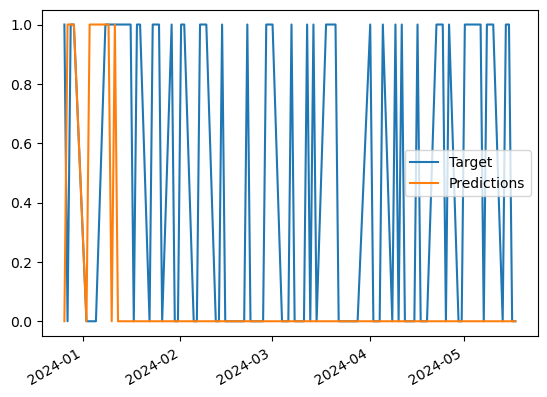

In [28]:
# Combine the actual target values and the predictions into one DataFrame
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

# Plot the combined DataFrame to visualize the predictions against the actual targets
combined.plot()

# Display the plot
plt.show()


## Backtesting

Our model isn't performing well currently, but we can still improve it. First, let's extend our predictions across the entire dataset instead of just the last 100 rows. This will provide a more robust error estimate, as the last 100 days might have had unique market conditions or other factors that make the error metrics unrealistic for future predictions (which are our primary concern).

In real-world scenarios, you wouldn't rely on an algorithm tested on just 100 days of data.

To test on more days, we'll implement backtesting. Backtesting ensures that we only use data available before the prediction day, making the algorithm more realistic. In real-world applications, you can't use future data to predict past events.

Our backtesting method will loop over the dataset and train a model every `750` rows. We'll encapsulate this in a function to avoid rewriting code for future backtests. Ideally, we'd train the model more frequently than every `750` rows, but we'll set this higher for speed.

Before writing the full backtesting loop, let's implement a single iteration. In this code snippet:

- We'll use the first 1000 rows as our training set.
- We'll use the next 750 rows as our testing set.
- We'll fit the machine learning model to the training set.
- We'll make predictions on the test set.

This approach is similar to our previous one but withtion of Backtesting


In [30]:
# Define the parameters for the iteration
i = 1000
step = 750

# Split the data into training and test sets
train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()

# Fit the model to the training set
model.fit(train[predictors], train["Target"])

# Make predictions on the test set
preds = model.predict(test[predictors])


### Predicting Probabilities

Next, let's refine our predictions to enhance precision. Currently, we're using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) method, which doesn't specifically optimize for `precision`. This method predicts an increase if the model thinks there's a 50% or higher chance of the price going up. 

To improve this, we'll adjust the threshold so the model only predicts an increase when it is more confident. We'll set this threshold to `0.6`.

To achieve this, we'll use the [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) method, which provides the raw probabilities instead of binary outcomes (`0/1`).

In the code below, we will:

- Use the `predict_proba` method to get the probabilities that the price will go up.
- Extract the second column of the result to get the probability of the price going up.
- Convert the result from a numpy array to a pandas Series for easier manipulation.
- Set the prediction to `1` (price going up) only if the probability is greater than `60%`.

Here's how we implement this:


In [32]:
# Use the predict_proba method to get the probabilities of the price going up
preds = model.predict_proba(test[predictors])[:,1]

# Convert the probabilities to a pandas Series
preds = pd.Series(preds, index=test.index)

# Apply the threshold: if the probability > 0.6, predict the price will go up (1), else predict 0
preds[preds > 0.6] = 1
preds[preds <= 0.6] = 0
# Display the first few rows
preds.head()


1990-02-27 05:00:00    1.0
1990-02-28 05:00:00    1.0
1990-03-01 05:00:00    1.0
1990-03-02 05:00:00    1.0
1990-03-05 05:00:00    1.0
dtype: float64

### Pulling it into a Loop

Next, we'll consolidate everything we've done into a loop. This loop will allow us to iterate over the entire dataset, generate predictions, and store them in the `predictions` list.

We'll generate predictions for all but the first 1000 rows of the dataset, as there is no prior data available to predict these initial rows.

In this loop, we will:

- Generate predictions on our train and test sets.
- Combine those predictions with the actual target values.
- Add all the combined predictions to a list.

By examining the first element of the `predictions` list, we can see both the actual `Target` and the `Predictions` made by our model.


In [34]:
# Initialize an empty list to store predictions
predictions = []

# Loop over the dataset in increments to generate predictions
for i in range(1000, data.shape[0], step):
    # Split the data into training and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    
    # Fit the model to the training set
    model.fit(train[predictors], train["Target"])
    
    # Use the predict_proba method to get the probabilities of the price going up
    preds = model.predict_proba(test[predictors])[:,1]
    
    # Convert the probabilities to a pandas Series
    preds = pd.Series(preds, index=test.index)
    
    # Apply the threshold: if the probability > 0.6, predict the price will go up (1), else predict 0
    preds[preds > 0.6] = 1
    preds[preds <= 0.6] = 0
    
    # Combine the predictions with the actual target values
    combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
    
    # Add the combined DataFrame to the predictions list
    predictions.append(combined)

# Concatenate all predictions into a single DataFrame
predictions = pd.concat(predictions)

# Display the first few rows of the predictions DataFrame to verify
print(predictions.head())


                     Target  Predictions
1990-02-27 05:00:00     0.0          1.0
1990-02-28 05:00:00     1.0          1.0
1990-03-01 05:00:00     1.0          1.0
1990-03-02 05:00:00     1.0          1.0
1990-03-05 05:00:00     1.0          1.0


### Creating a Backtesting Function

Finally, we'll wrap the loop in a function to make it easier to work with. Encapsulating the loop in a function allows us to call it conveniently whenever needed. The function will take the `data`, the machine learning `model`, and the `predictors` as inputs. We'll also include `start` and `step` as optional parameters.

In the backtesting function, we will:

- Split the training and test data.
- Train the model.
- Make predictions on the test data using `predict_proba`.
- Combine our predictions with the actual target values to calculate errors easily.
- Return all the predictions.

This function will enable us to generate predictions across the entire dataset whenever needed.


In [36]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into training and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the model
        model.fit(train[predictors], train["Target"])
        
        # Generate predictions using predict_proba
        preds = model.predict_proba(test[predictors])[:,1]
        
        # Convert probabilities to binary predictions based on threshold
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0
        
        # Combine predictions with actual target values
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        
        # Add combined data to the predictions list
        predictions.append(combined)
    
    # Concatenate all predictions into a single DataFrame
    return pd.concat(predictions)



### Running the Function

Now that we've created a backtesting function, we can call it to generate predictions across the entire dataset.


In [38]:
# Run the backtesting function to generate predictions across the entire dataset
predictions = backtest(data, model, predictors)


Next, let's use the [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts) method to identify how many times the algorithm predicted the price would go up versus down.

As shown below, the algorithm predicted the price would go up `751` times. However, in the `Target`, the price actually went up `4371` times. This indicates that the algorithm predicted the price increase far fewer times than it actually occurred, resulting in low `recall`, which measures the percentage of true positive predictions among all actual positive instances.

This low recall is because we used `0.6` as the threshold for predicting price increases. If we used a lower threshold, recall would increase, but precision would decrease. Since we aim to minimize risk, maximizing precision is more important. Therefore, it's acceptable for the algorithm to predict price increases on fewer days.
ys.


In [40]:
# Use the value_counts method to see the distribution of predictions
predictions_count = predictions["Predictions"].value_counts()
target_count = predictions["Target"].value_counts()

# Display the counts
print("Predictions Distribution:\n", predictions_count)
print("Actual Target Distribution:\n", target_count)


Predictions Distribution:
 Predictions
0.0    7871
1.0     751
Name: count, dtype: int64
Actual Target Distribution:
 Target
1.0    4371
0.0    4251
Name: count, dtype: int64


Finally, let's evaluate the precision of our predictions. We'll use the same function as before to calculate this.

It appears that our precision is also low. This is likely because the algorithm has a limited set of `predictors` to help it determine whether the price will go up or down. To improve the model's performance, we will need to add more predictors to provide the algorithm with better information for making decisions.


In [42]:
# Calculate and display the precision of the predictions
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Precision: {precision}")


Precision: 0.5006657789613849


## Improving Accuracy

Our model isn't very accurate, but now we can make predictions across the entire history of the stock. To make this model useful, we need to improve its prediction accuracy.

Let's add some more predictors to see if we can enhance the model's accuracy.

We'll include rolling means to help the model evaluate the current price against recent prices and consider the ratios between different indicators.

### Rolling Means

Rolling means are useful because they help the algorithm compare the current price to the average price over various periods, such as a week, quarter, or year. For instance, if the current price is higher than the annual average, it might indicate an upward trend.

To calculate the rolling averages, we'll use the pandas [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html?highlight=rolling#pandas.DataFrame.rolling) method to find the rolling mean of the `Close` column for different time horizons.


In [44]:
# Calculate rolling means for different time horizons
weekly_mean = data['Actual_Close'].rolling(window=7).mean()
quarterly_mean = data['Actual_Close'].rolling(window=90).mean()
annual_mean = data['Actual_Close'].rolling(window=365).mean()

We can also provide the algorithm with information on how many days in the last week the price has gone up. This can be achieved using the pandas `shift` and `rolling` methods:

- We'll shift the data forward to ensure we don't incorporate information from the current day into our predictor. Without the shift, the algorithm would have knowledge of the actual target, which is unrealistic.
- We'll then calculate the 7-day rolling sum of the target. If the price went up all 7 days, the sum would be `7`. If it went up 0 days, the sum would be `0`.


In [46]:
# Calculate the 7-day rolling sum of the shifted target
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

Now, we're ready to add our ratios into our predictor DataFrame.

First, we'll add the ratios between the weekly, quarterly, and annual means to the close price:


In [48]:
# Add ratios between the rolling means and the close price
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]


Next, we'll add the ratios between different rolling means. This helps the algorithm understand how the weekly trend compares to the annual trend.


In [50]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

Next, we'll add our weekly trend into the predictor DataFrame.

In [52]:
data["weekly_trend"] = weekly_trend

Then, we'll add some ratios between intraday open, low, and high prices and the close price. This helps the algorithm understand what the price trend was during the last day. For example, if the high was much higher than the close price, it may indicate that the stock was on a downward trend at the end of the day.


In [54]:
# Add ratios between intraday open, low, high prices, and the close price
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]


Finally, we'll update our `predictors` list with all of the new predictors we've added. This ensures that we use all of our new predictors when training the model.


In [56]:
# Update the list of predictors to include the new features
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
# Display the updated list of predictors
print(full_predictors)


['Close', 'Volume', 'Open', 'High', 'Low', 'weekly_mean', 'quarterly_mean', 'annual_mean', 'annual_weekly_mean', 'annual_quarterly_mean', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio', 'weekly_trend']


### Updating Our Predictions

We can now update our predictions using the new set of predictors. We need to cut off the first `365` rows because our rolling means will have `NaN` values for the initial `365` rows. This ensures we have consistent data for each row we make predictions for.

Let's run the backtesting function again with the updated list of predictors.

As we can see, our predictions should be more accurate than before!


In [58]:
# Run the backtesting function with the updated list of predictors
predictions = backtest(data.iloc[365:], model, full_predictors)

# Calculate and display the precision of the updated predictions
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Updated Precision: {precision}")




Updated Precision: 0.6611295681063123


### Evaluating Our Predictions

Now, we can check how many trades we would have made using the updated algorithm. We can do this again with the `value_counts` method.

As shown below, we would have made `602` trades using this algorithm, with a nearly `66%` chance that the price went up when our algorithm predicted it would. This is a decent start, but there are many steps we can take to further improve the algorithm!



Predictions Distribution:
 Predictions
0.0    7655
1.0     602
Name: count, dtype: int64
Updated Precision: 0.6611295681063123


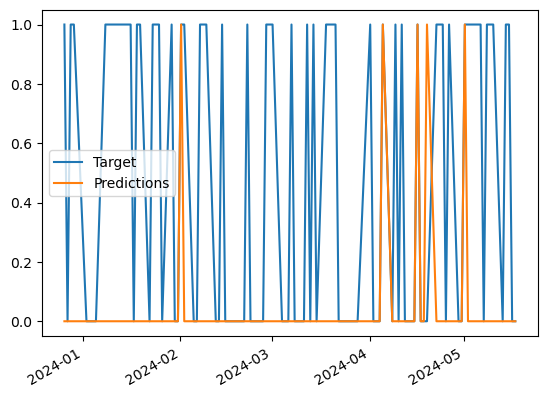

In [60]:
# Use the value_counts method to see the distribution of predictions
predictions_count = predictions["Predictions"].value_counts()

# Display the counts
print("Predictions Distribution:\n", predictions_count)

# Calculate and display the precision of the updated predictions
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Updated Precision: {precision}")

# Look at trades we would have made in the last 100 days
last_100_days = predictions.iloc[-100:].plot()
plt.show()


## Next Steps

We've come a long way in this project! So far, we have:

- Downloaded data for a stock
- Cleaned and explored the data
- Created a machine learning model
- Created a backtesting function
- Improved our predictions

We now have a model that we can continue to build on and tweak. The biggest area we can improve is the accuracy of our predictions.

There are several next steps we could take:

### Improve the Technique

- Calculate how much money you'd make if you traded with this algorithm.

### Improve the Algorithm

- Run with a reduced step size. This will take longer but increase accuracy.
- Try discarding older data and only keeping data within a certain window.
- Experiment with different machine learning algorithms.
- Tweak random forest parameters or the prediction threshold.

### Add More Predictors

- **Intraday Trading Data:**
  - Add hourly trends from the day before.
- **Post-Close and Pre-Open Activity:**
  - Include early trading data.
  - Incorporate trading data from other exchanges that open before the NYSE to gauge global sentiment.
- **Economic Indicators:**
  - Interest rates.
  - Other significant economic news.
- **Key Dates:**
  - Dividends.
  - External factors such as elections.
- **Company Milestones:**
  - Earnings calls.
  - Analyst ratings.
  - Major announcements.
- **Prices of Related Stocks:**
  - Other companies in the same
Stay tuned for more project walkthrough posts!
